In [1]:
!pip3 -q install timm 
!pip3 -q install pybboxes
!pip -q install albumentations
!pip -qinstall torch torchvision
!pip3 -q install "omegaconf>=2.0"
!pip3 -q install "ensemble-boxes==1.0.6"
!pip3 -q install "pycocotools>=2.0.2"
!git clone https://github.com/rwightman/efficientdet-pytorch.git


Usage:   
  pip <command> [options]

no such option: -i
fatal: destination path 'efficientdet-pytorch' already exists and is not an empty directory.


In [1]:
import os
import gc
import sys
sys.path.insert(0, "./efficientdet-pytorch")
import cv2
import timm
import time
import shutil
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
import pybboxes as pbx
from pprint import pprint
from matplotlib import patches
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from ensemble_boxes import ensemble_boxes_wbf

class cfg:
    DEBUG = False
    path = './data/PART_1/PART_1/'
    path2category1 = './data/PART_1/PART_1/1category'
    path2images = './data/PART_1/PART_1/images/'
    path2drive = './drive/MyDrive'
    log_dir = './logs'
    model_dir = './models'
    data_dir = './data/'
    n_epochs = 10
    eta_min = 1e-6
    use_amp = True
    kernel_type = 'fastercnn_resnet50'

os.makedirs(cfg.data_dir, exist_ok=True)
os.makedirs(cfg.log_dir, exist_ok=True)
os.makedirs(cfg.model_dir, exist_ok=True)

if os.path.exists("./PART_1") or os.path.exists("./PART_2") or os.path.exists("./PART_3"):
    shutil.move("./PART_1", "./data/PART_1")
    shutil.move("./PART_2", "./data/PART_2")
    shutil.move("./PART_3", "./data/PART_3")

In [2]:
data = os.listdir(os.path.join(cfg.path, 'images'))
df = pd.DataFrame({
    "images": data
})
df['dir_path'] = cfg.path
df['path2img'] = df['dir_path'] + '/' + df['images']

list_of_imgs = sorted(df['images'].apply(lambda x: x[:-4]).tolist())

# `1category` contains bounding box coordinates for all images
category_one_data = os.listdir(os.path.join(cfg.path, '1category'))
category_one_df = pd.DataFrame({
    "1category": sorted(category_one_data)
})

# `images` in `part1` only contain `1/3` of all images
# the rest of the 2/3 of images are in `part2` and `part3`
# so we need to filter out only the bounding box coordinates for images in `part1` from `1category`
list_of_1category_labels = category_one_df['1category'].apply(lambda x: x[:-4]).tolist()
filtered_1category_labels = sorted(list(set(list_of_1category_labels).intersection(list_of_imgs)))

data = filtered_1category_labels.copy()
filtered_1category_labels_df = pd.DataFrame({
    '1category': data
})
# filtered_1category_labels_df['1category'] = filtered_1category_labels_df['1category'].apply(lambda x: x+'.txt')
filtered_1category_labels_df['1category'] = filtered_1category_labels_df['1category'] + '.txt'

# https://stackoverflow.com/questions/36133716/how-to-skip-reading-empty-files-with-panda-in-python
def is_non_zero_file(fpath):  
    """check if file is empty"""
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0

data = sorted(os.listdir(cfg.path2category1))
category1length = len(os.listdir(cfg.path2category1))
target_cols = ['x', 'y', 'w', 'h']
tmp_arr = []
filename_arr = []

for i in tqdm(range(category1length), total=category1length):
    file = data[i]
    filename_arr.append(file)
    filepath = os.path.join(cfg.path2category1, file)
    if not is_non_zero_file(filepath):
        tmp_arr.append('[]')
        continue
    else:
        tmp_df = pd.read_csv(os.path.join(cfg.path2category1, file), sep=" ", header=None).drop([0], axis=1).rename(columns={1: "x", 2: "y", 3: "w", 4: "h"})
        bbox_targs = tmp_df[target_cols].values.tolist()
        tmp_arr.append(bbox_targs)

bbox_df_category1 = pd.DataFrame({
    'filename': filename_arr,
    'bbox': tmp_arr
})
bbox_df_category1.head()

# files that contain bounding box coordinates for images only in part1
x = filtered_1category_labels_df['1category'].tolist()

bbox_filtered_df_category1 = bbox_df_category1[bbox_df_category1['filename'].isin(x)]

# filter out the rows where there are no bounding box coordinates
# filter out images where there are no bounding boxes
bbox_filtered_df_category1 = bbox_filtered_df_category1[bbox_filtered_df_category1['bbox'] != '[]'].reset_index(drop=True)

# append .jpg to end of img_file
bbox_filtered_df_category1['img_file'] = bbox_filtered_df_category1['filename'].apply(lambda x: x[:-4]+'.jpg')

100%|██████████| 3641/3641 [00:04<00:00, 785.45it/s] 


In [3]:
folds = bbox_filtered_df_category1.copy()
kf = KFold(5)
folds['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(folds, folds)):
    folds.loc[valid_idx, 'fold'] = fold
    
# save dataset
folds.to_csv(f'./data/afo_clean_dataset.csv', index=False)
folds.tail()

,filename,bbox,img_file,fold
970,d_454.txt,"[[0.3260416666666667, 0.6722222222222223, 0.03...",d_454.jpg,4
971,d_455.txt,"[[0.3244791666666666, 0.6712962962962963, 0.03...",d_455.jpg,4
972,dv_0.txt,"[[0.6442708333333333, 0.6625, 0.01223958333333...",dv_0.jpg,4
973,dv_1199.txt,"[[0.38203125, 0.6467592592592593, 0.0080729166...",dv_1199.jpg,4
974,dv_1409.txt,"[[0.378125, 0.5643518518518519, 0.01171875, 0....",dv_1409.jpg,4


In [4]:
def create_model(num_classes=1, image_size=256, architecture="tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )
    
    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})
    
    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

In [5]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Resize(256, 256, p=1.0),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Resize(256, 256, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
class AFODataset(Dataset):
  
    def __init__(self, df, transforms=None):
        super().__init__()

        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index: int):
        img_file = self.df['img_file'].values[index] 
        bboxes = self.df['bbox'].values[index]
        records = len(bboxes)
        
        image = cv2.imread(f'{cfg.path2images}{img_file}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        converted_bboxes = []
        for bbox in bboxes:
            W, H = image.shape[1], image.shape[0]  
            yolo_bbox = tuple(bbox)
            x,y,w,h = pbx.convert_bbox(yolo_bbox, from_type="yolo", to_type="voc", image_size=(W, H))
            new_bboxes = [x,y,w,h]
            converted_bboxes.append(new_bboxes)

        # there is only one class
        labels = torch.ones((records,), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records,), dtype=torch.int64)

        target = {}
        target['boxes'] = torch.tensor(converted_bboxes)
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['iscrowd'] = iscrowd
        target["img_size"] = (320, 320),
        target["img_scale"] = torch.tensor([1.0]),

        if self.transforms:
            for i in range(10):
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels,
                    'img_size': target['img_size'],
                    'img_scale': target['img_scale']
                }
                sample = self.transforms(**sample)
                image = sample['image']
                _, new_h, new_w = image.shape

                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning

                    target = {
                        "boxes": target['boxes'],
                        "labels": labels,
                        "img_size": (new_h, new_w),
                        "img_scale": torch.tensor([1.0]),
                    }

                    break

        return torch.tensor(image), target, img_file

In [7]:
show_dataset = AFODataset(folds, get_valid_transform())
image, target, img_file = show_dataset[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


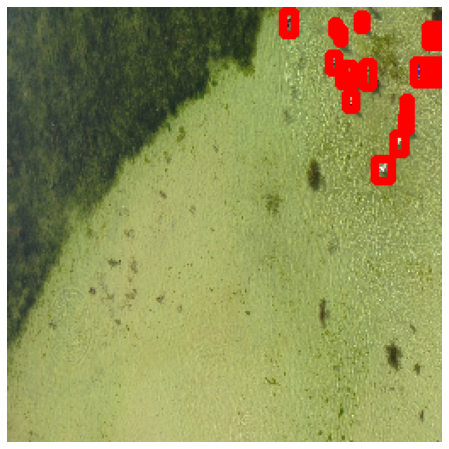

In [8]:
image = image.permute(1,2,0).cpu().numpy()
bbox = target['boxes'].cpu().numpy().astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in bbox:
    cv2.rectangle(image,
                  # (box[0], box[1]),
                  # (box[2], box[3]),
                  # y,x,h,w
                  (box[1], box[0]),
                  (box[3], box[2]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(image)

In [10]:
def train_fn(model, loader_train, optimizer, scaler, device):
    model.train()

    train_loss = []
    bar = tqdm(loader_train)
    for images, targets, image_ids in bar:
        optimizer.zero_grad()

        images = torch.stack(images)
        images = images.to(device).float()
        boxes = [target["boxes"].to(device).float() for target in targets]
        labels = [target["labels"].to(device).float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        target = {
          "bbox": boxes,
          "cls": labels,
          "img_size": img_size,
          "img_scale": img_scale
        }

        loss_dict = model(images, target)

        with amp.autocast():
            loss_dict = model(images, target)
            loss = sum(loss for loss in loss_dict.values())

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')
    return np.mean(train_loss)

In [11]:
def run(fold):
    
    def collate_fn(batch):
        return tuple(zip(*batch))

    log_file = os.path.join(cfg.log_dir, f'{cfg.kernel_type}.txt')
    model_file = os.path.join(cfg.model_dir, f'{cfg.kernel_type}_fold{fold}_best.pth')

    train_ds = folds[folds['fold'] != fold].reset_index(drop=True)
    # valid_ds = folds[folds['fold'] == fold].reset_index(drop=True)

    train_dataset = AFODataset(train_ds, transforms=get_train_transform())
    # valid_dataset = AFODataset(valid_ds, transforms=get_valid_transform())

    train_data_loader = DataLoader(
      train_dataset,
      batch_size=8,
      shuffle=False,
      num_workers=4,
      collate_fn=collate_fn
    )

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = create_model()

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    scheduler_cosine = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, cfg.n_epochs, eta_min=cfg.eta_min)
    scaler = torch.cuda.amp.GradScaler() if cfg.use_amp else None
    model = model.to(device)
    model.load_state_dict(torch.load(f'./{cfg.model_dir}/fastercnn_resnet50_fold0_best.pth'))

    metric_best = np.inf
    loss_min = np.inf

    for epoch in range(1, cfg.n_epochs+1):
        scheduler_cosine.step(epoch-1)

        train_loss = train_fn(model, train_data_loader, optimizer, scaler, device)
        metric = train_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}.'
        print(content)

        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric
    
        # Save Last
        if not cfg.DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'loss_minimum': metric_best,
                },
                model_file.replace('_best', '_last')
            )

        # del model
        torch.cuda.empty_cache()
        gc.collect()

In [12]:
run(0)

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [256, 256], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_l-d664b728.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_l-d664b728.pth
smth:0.7159: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Mon Nov 28 23:58:33 2022 Fold 0, Epoch 1, lr: 0.0050000, train loss: 0.74802.
metric_best (inf --> 0.748021). Saving model ...


smth:0.7350: 100%|██████████| 98/98 [00:45<00:00,  2.14it/s]


Mon Nov 28 23:59:47 2022 Fold 0, Epoch 2, lr: 0.0048777, train loss: 0.74174.
metric_best (0.748021 --> 0.741737). Saving model ...


smth:0.6816: 100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


Tue Nov 29 00:01:01 2022 Fold 0, Epoch 3, lr: 0.0045226, train loss: 0.71443.
metric_best (0.741737 --> 0.714428). Saving model ...


smth:0.6813: 100%|██████████| 98/98 [00:45<00:00,  2.13it/s]


Tue Nov 29 00:02:11 2022 Fold 0, Epoch 4, lr: 0.0039697, train loss: 0.70774.
metric_best (0.714428 --> 0.707744). Saving model ...


smth:0.6567: 100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


Tue Nov 29 00:03:25 2022 Fold 0, Epoch 5, lr: 0.0032729, train loss: 0.70448.
metric_best (0.707744 --> 0.704477). Saving model ...


smth:0.6472: 100%|██████████| 98/98 [00:45<00:00,  2.13it/s]


Tue Nov 29 00:04:42 2022 Fold 0, Epoch 6, lr: 0.0025005, train loss: 0.67833.
metric_best (0.704477 --> 0.678329). Saving model ...


smth:0.6210: 100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


Tue Nov 29 00:05:55 2022 Fold 0, Epoch 7, lr: 0.0017281, train loss: 0.66004.
metric_best (0.678329 --> 0.660036). Saving model ...


smth:0.6040: 100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


Tue Nov 29 00:07:10 2022 Fold 0, Epoch 8, lr: 0.0010313, train loss: 0.66407.


smth:0.6163: 100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


Tue Nov 29 00:08:18 2022 Fold 0, Epoch 9, lr: 0.0004784, train loss: 0.66915.


smth:0.6016: 100%|██████████| 98/98 [00:45<00:00,  2.14it/s]


Tue Nov 29 00:09:28 2022 Fold 0, Epoch 10, lr: 0.0001233, train loss: 0.66618.


In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

valid_ds = folds[folds['fold'] == fold].reset_index(drop=True)
valid_dataset = AFODataset(valid_ds, transforms=get_valid_transform())
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cpu_device = torch.device("cpu")
model = create_model()
model.load_state_dict(torch.load(f'./{cfg.model_dir}/fastercnn_resnet50_fold0_best.pth'))
model.to(device)
model.eval()

images, targets, image_ids = next(iter(valid_data_loader))

images = list(img.to(device) for img in images)

boxes = [target["boxes"].float() for target in targets]
labels = [target["labels"].float() for target in targets]
img_size = torch.tensor([target["img_size"] for target in targets]).float()
img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [256, 256], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

In [14]:
images = torch.stack(images)
images = images.to(device).float()

boxes = [torch.zeros(target["boxes"].shape).to(device).float() for target in targets]
labels = [torch.zeros(target["labels"].shape).to(device).float() for target in targets]
img_size = torch.tensor([target["img_size"] for target in targets]).to(device).float()
img_scale = torch.tensor([target["img_scale"] for target in targets]).to(device).float()

In [15]:
target = {
    "bbox": boxes,
    "cls": labels,
    "img_size": img_size,
    "img_scale": img_scale
}

In [16]:
def run_wbf(predictions, image_size=256, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels

def post_process_detections(detections):
    predictions = []
    for i in range(detections.shape[0]):
        predictions.append(
            _postprocess_single_prediction_detections(detections[i])
        )

    predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
        predictions, image_size=256, iou_thr=0.4
    )

    return predicted_bboxes, predicted_class_confidences, predicted_class_labels

def _postprocess_single_prediction_detections(detections):
    prediction_confidence_threshold = 0.1
    boxes = detections.detach().cpu().numpy()[:, :4]
    scores = detections.detach().cpu().numpy()[:, 4]
    classes = detections.detach().cpu().numpy()[:, 5]
    indexes = np.where(scores > prediction_confidence_threshold)[0]
    boxes = boxes[indexes]

    return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

def __rescale_bboxes(predicted_bboxes, image_sizes):
    img_size = 256
    scaled_bboxes = []
    for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
        im_h, im_w = img_dims

        if len(bboxes) > 0:
            scaled_bboxes.append(
                (
                  np.array(bboxes)
                  * [
                      im_w / img_size,
                      im_h / img_size,
                      im_w / img_size,
                      im_h / img_size,
                  ]
                ).tolist()
              )
        else:
            scaled_bboxes.append(bboxes)

    return scaled_bboxes

In [17]:
model.eval()
out = model(images, target)
print(out['detections'].shape)
print(out.keys())

torch.Size([8, 100, 6])
dict_keys(['loss', 'class_loss', 'box_loss', 'detections'])


In [18]:
detections = out['detections']
predictions = []
for i in range(detections.shape[0]):
    predictions.append(
        _postprocess_single_prediction_detections(detections[i])
    )

predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
    predictions, image_size=256, iou_thr=0.4
)

scaled_bboxes = __rescale_bboxes(
    predicted_bboxes=predicted_bboxes, image_sizes=img_size.cpu().numpy()
)

In [19]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
    plot_ax,
    bboxes,
    get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
    image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

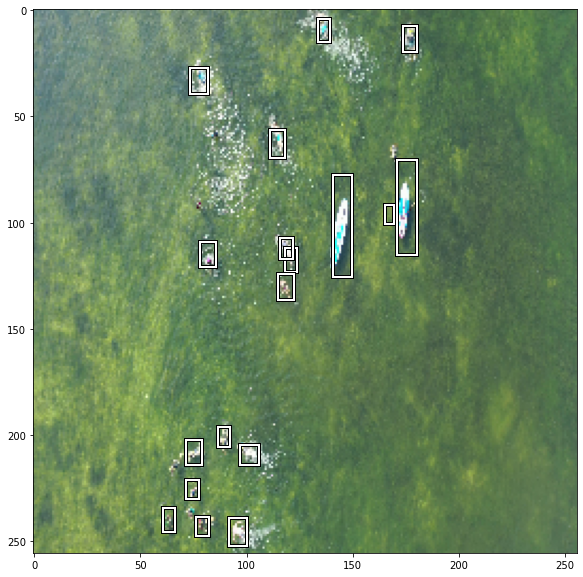

In [20]:
show_image(images[2].permute(1,2,0).cpu().numpy(), scaled_bboxes[2])